In [2]:
import numpy as np

import cvxpy as cp

from qutip import coherent, ket2dm, Qobj, expect, fidelity, fock, fock_dm, displace, coherent_dm
from qutip.visualization import plot_wigner_fock_distribution, plot_fock_distribution
from qutip.wigner import qfunc

from tqdm.auto import tqdm # progress bar

import matplotlib.pyplot as plt
from matplotlib import colors
from joblib import Parallel, delayed

### Define Q-function measurement operators

In [3]:
def qfunc_ops(hilbert_size, beta):
    
    # need the larger Hilbert space to not get erroneous operators for large beta
    op = coherent_dm(hilbert_size*2, beta)/np.pi
    op = Qobj(op[:hilbert_size, :hilbert_size]) # truncate to wanted Hilbert space size
        
    return op

### Define a state $\rho$ to test the tomography on
Here a cat state $|\psi\rangle=\dfrac{|\alpha\rangle+|-\alpha\rangle}{\sqrt{2}}, \quad \alpha=2.$

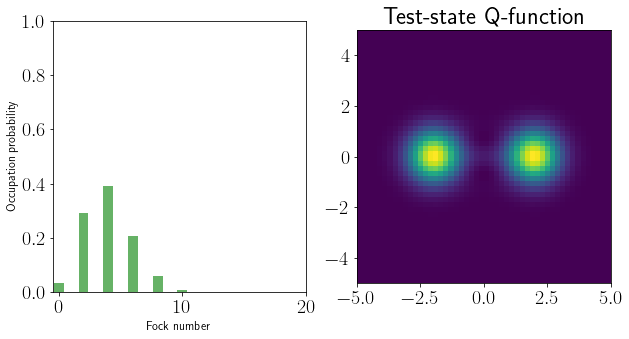

In [13]:
# Fock space dimension
N = 20

# Coherent state amplitudes for test cat state
alpha_range = 2
alphas = np.array([alpha_range, -alpha_range])
                  
# Test-state 
psi = sum([coherent(N, a) for a in alphas])
psi = psi.unit()
rho = ket2dm(psi)

alpha_max = 5 # setting the limits on the Wigner plot

fig, ax = plt.subplots(1,2, figsize=(10, 5))
plot_fock_distribution(rho, ax=ax[0])

xvec = np.linspace(-alpha_max, alpha_max)
yvec = xvec
q = qfunc(rho, xvec, yvec, g=2)
plt.imshow(q,extent=[-alpha_max, alpha_max,-alpha_max, alpha_max])
plt.title("Test-state Q-function");

### Construct the operator basis: Fock basis
The list `basis_dms` contains all $\Omega_k$

In [8]:
# construct vectors
basis_vectors = []
for i in range(N):
    vector = fock(N, i)
    basis_vectors.append(np.real(vector.full()))
    
# construct operators
basis_dms = []
for vector1 in basis_vectors:
    for vector2 in basis_vectors:
        dm = np.outer(vector1, vector2)
        basis_dms.append(dm)

### Measurement settings
Define coherent probe states $|\beta\rangle$ on a square grid in phase space.

In [16]:
# Maximum coherent state amplitude
beta_max = 4

# number of probes in the x/p direction
nm = 15

xvec_betas = np.linspace(-beta_max, beta_max, nm)
yvec_betas = np.linspace(-beta_max, beta_max, nm)

X, Y = np.meshgrid(xvec_betas, yvec_betas)

# flatten the grid of probe states into a 1D array
betas = (X + 1j*Y).ravel()

Superpose the measurement grid on the Q-function just to check.

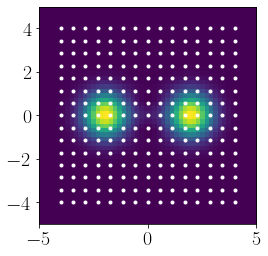

In [17]:
plt.imshow(q, extent=[-alpha_max, alpha_max,-alpha_max, alpha_max])
plt.plot(betas.real, betas.imag, 'w.');

#### Assign measurement operators $\Pi$ with the measurement settings

In [18]:
Pis = Parallel(n_jobs=16, verbose=5, backend="multiprocessing")(delayed(qfunc_ops)(N,beta) for beta in betas)

[Parallel(n_jobs=16)]: Using backend MultiprocessingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  48 tasks      | elapsed:    2.7s
[Parallel(n_jobs=16)]: Done 178 tasks      | elapsed:    7.6s
[Parallel(n_jobs=16)]: Done 225 out of 225 | elapsed:    9.7s finished


### Construct the matrix A in $A\vec\rho=\vec b$
From `Pis` and `basis_dms`.

In [19]:
def func(index, a):
    return np.trace(Pis[index[0]].full() @ basis_dms[index[1]])

A = np.zeros((len(Pis), N*N), dtype=np.complex64)
A_p = Parallel(n_jobs=16, verbose=5, backend="multiprocessing")(delayed(func)(idx,a) for idx, a in np.ndenumerate(A))

A = np.reshape(A_p, (len(Pis), N*N))

[Parallel(n_jobs=16)]: Using backend MultiprocessingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  48 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 512 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 8160 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 84388 tasks      | elapsed:    1.3s
[Parallel(n_jobs=16)]: Done 90000 out of 90000 | elapsed:    1.4s finished


### Construct simulated "measurement results" $\vec b$

In [20]:
b = expect(Pis, rho)
b = np.array(b)

## Convex optimization

Define the unknown state as a $N\times N$ Hermitian matrix

In [21]:
X = cp.Variable((N,N), hermitian=True)

Set the cost function to $\|A\vec\rho - \vec b\|_2$ where the vectorized state is given by `cp.reshape(X, (N*N))`

In [22]:
cost = cp.norm(A @ cp.reshape(X, (N*N)) - b, 2);

Set the trace constraint and positive-semidefinite constraint, respectively.

In [23]:
constraints = [cp.trace(X) == 1, X >> 0 ]

Set up and solve the problem!

In [26]:
prob = cp.Problem(cp.Minimize(cost), constraints)
prob.solve();

WARN: A->p (column pointers) not strictly increasing, column 436 empty
WARN: A->p (column pointers) not strictly increasing, column 457 empty
WARN: A->p (column pointers) not strictly increasing, column 478 empty
WARN: A->p (column pointers) not strictly increasing, column 499 empty
WARN: A->p (column pointers) not strictly increasing, column 520 empty
WARN: A->p (column pointers) not strictly increasing, column 541 empty
WARN: A->p (column pointers) not strictly increasing, column 562 empty
WARN: A->p (column pointers) not strictly increasing, column 583 empty
WARN: A->p (column pointers) not strictly increasing, column 604 empty
WARN: A->p (column pointers) not strictly increasing, column 625 empty
WARN: A->p (column pointers) not strictly increasing, column 646 empty
WARN: A->p (column pointers) not strictly increasing, column 667 empty
WARN: A->p (column pointers) not strictly increasing, column 688 empty
WARN: A->p (column pointers) not strictly increasing, column 709 empty
WARN: 

In [27]:
# Assign the optimized state X to a Qobj.

reconstructed_rho = Qobj(X.value)

### Visualize results

Plot the reconstructed state and show the fidelity

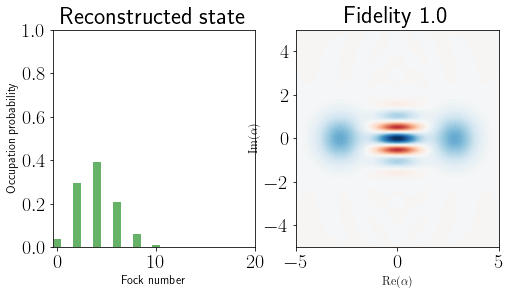

In [37]:
fig, ax = plot_wigner_fock_distribution(reconstructed_rho, alpha_max=alpha_max)
ax[0].set_title("Reconstructed state");

plt.title("Fidelity {:.3}".format(fidelity(reconstructed_rho, Qobj(rho))**2));


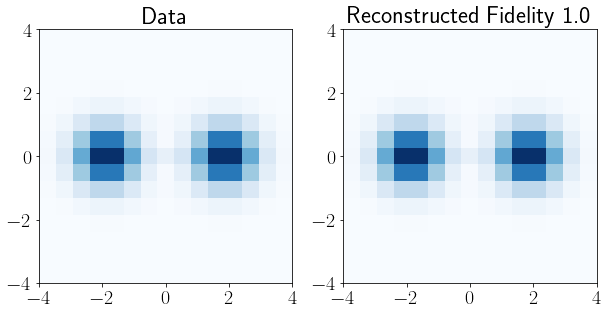

In [36]:
q = qfunc(Qobj(reconstructed_rho), xvec_betas, xvec_betas, g=2)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

data_img = ax[0].imshow(b.reshape((nm, nm)), cmap="Blues",extent=[-beta_max, beta_max, -beta_max, beta_max])
ax[0].set_title("Data")
#plt.colorbar(data_img, ax=ax[0], shrink=0.75)

reconst_img = ax[1].imshow(q, cmap="Blues", extent=[-beta_max, beta_max, -beta_max, beta_max])
ax[1].set_title("Reconstructed Fidelity {:.3}".format(fidelity(reconstructed_rho, Qobj(rho))));
#plt.colorbar(reconst_img, ax=ax[1], shrink=0.75);

In [174]:
fidelity(reconstructed_rho, Qobj(rho))

0.9999924343642665